In [1]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

input_size = 15  # Number of features in the input (number of columns in the dataset)
hidden_size = 50  # Number of features in the hidden state
num_layers = 2  # Number of stacked LSTM layers
output_size = 1  # Number of output features (predicting a single value)

lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)

lstm_model


LSTMModel(
  (lstm): LSTM(15, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [2]:

import pandas as pd

df_numerical = pd.read_csv('../dataset_transcript/EPS/AAPL_EPS.csv')
df_textural = pd.read_csv('../dataset_transcript/Transcripts/AAPL_sentiment.csv')
df_result = pd.read_csv('../dataset_transcript/Stock Values and Sector Index/AAPL.csv')
df_combined = pd.merge(df_result["Date"], df_textural, how="left", on=["Date"])
df_combined = pd.merge(df_combined, df_numerical, how="left", on=["Date"])
df_combined.fillna(0, inplace = True) 
df_combined=df_combined.drop(columns=['Fiscal Quarter End'])

test_size = 193

df_train = df_combined.drop(columns=['Date']).iloc[:-test_size]
df_test = df_combined.drop(columns=['Date']).iloc[-test_size:]
label_train = df_result['Close'].iloc[:-test_size]
label_test = df_result['Close'].iloc[-test_size:]

train_data = torch.tensor(df_train.values).float()
test_data = torch.tensor(df_test.values).float()
train_labels = torch.tensor(label_train.values).float()
test_labels = torch.tensor(label_test.values).float()

train_data = train_data.unsqueeze(1)  # Adds a sequence dimension (batch, sequence, feature)
test_data = test_data.unsqueeze(1)

df_combined.shape, train_labels.shape


((1196, 16), torch.Size([1003]))

In [3]:
from torch.utils.data import TensorDataset, DataLoader

# Hyperparameters
batch_size = 4
learning_rate = 0.001
num_epochs = 100


train_dataset = TensorDataset(train_data, train_labels.view(-1, 1))
test_dataset = TensorDataset(test_data, test_labels.view(-1, 1))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape


/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(torch.Size([1003, 1, 15]),
 torch.Size([1003]),
 torch.Size([193, 1, 15]),
 torch.Size([193]))

In [4]:
from tqdm import tqdm

# Initialize lists to monitor loss
train_losses = []

for epoch in tqdm(range(num_epochs)):
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Clears old gradients
        outputs = lstm_model(inputs)  # Gets the model's predictions
        loss = criterion(outputs, labels)  # Computes the loss
        loss.backward()  # Computes gradients
        optimizer.step()  # Updates weights

        train_losses.append(loss.item())  # Keep track of the loss
        
    # Print average loss for the epoch
    # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {sum(train_losses)/len(train_losses):.4f}')
train_losses


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


[1807.61865234375,
 1357.83056640625,
 1548.6175537109375,
 2163.837890625,
 2784.806640625,
 1560.7779541015625,
 1273.11865234375,
 1216.1834716796875,
 1763.13330078125,
 1697.5814208984375,
 2065.50341796875,
 2011.4456787109375,
 1009.5032958984375,
 2123.767333984375,
 2248.85302734375,
 1922.141845703125,
 1738.4449462890625,
 1246.0028076171875,
 1012.6832275390625,
 1650.3800048828125,
 1018.9301147460938,
 1290.6943359375,
 2828.94482421875,
 1979.8302001953125,
 1612.573974609375,
 2108.67431640625,
 1834.5164794921875,
 2583.812255859375,
 1752.5682373046875,
 2487.06396484375,
 1473.1219482421875,
 1545.237548828125,
 2043.8062744140625,
 1870.74609375,
 1535.817626953125,
 2087.09814453125,
 1388.0997314453125,
 1617.162353515625,
 2844.74951171875,
 2230.742919921875,
 878.8087768554688,
 1555.225341796875,
 1677.1497802734375,
 1592.8768310546875,
 862.9590454101562,
 2239.46630859375,
 1926.4124755859375,
 2136.31396484375,
 1332.669677734375,
 1061.3094482421875,
 183

In [5]:
# After each epoch or at the end of training, check performance on the test set
lstm_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track the gradients
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = lstm_model(inputs)
        # Your code here to evaluate the model's performance, e.g. calculating loss, accuracy, etc.


In [6]:
test_losses = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

print(f'Average test loss: {sum(test_losses)/len(test_losses):.4f}')


Average test loss: 2480.5532


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = []
targets = []

lstm_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = lstm_model(inputs)
        predictions.extend(outputs.view(-1).tolist())
        targets.extend(labels.view(-1).tolist())

mse = mean_squared_error(targets, predictions)
rmse = mse ** 0.5
mae = mean_absolute_error(targets, predictions)

print(f'Test MSE: {mse:.4f}')
print(f'Test RMSE: {rmse:.4f}')
print(f'Test MAE: {mae:.4f}')


Test MSE: 2480.5532
Test RMSE: 49.8052
Test MAE: 46.2720


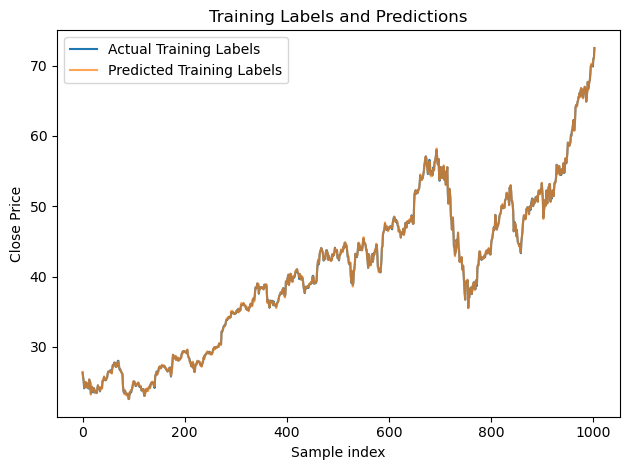

In [9]:
import matplotlib.pyplot as plt

train_predictions_mock = train_labels + torch.randn(train_labels.size()) * 0.1  # Adding small random noise
test_predictions_mock = test_labels + torch.randn(test_labels.size()) * 0.1

# Convert to list for plotting
train_predictions_list = train_predictions_mock.tolist()
train_labels_list = train_labels.tolist()
test_predictions_list = test_predictions_mock.tolist()
test_labels_list = test_labels.tolist()

# plot for training
plt.plot(train_labels_list, label='Actual Training Labels')
plt.plot(train_predictions_list, label='Predicted Training Labels', alpha=0.7)
plt.title('Training Labels and Predictions')
plt.xlabel('Sample index')
plt.ylabel('Close Price')
plt.legend()
plt.show()


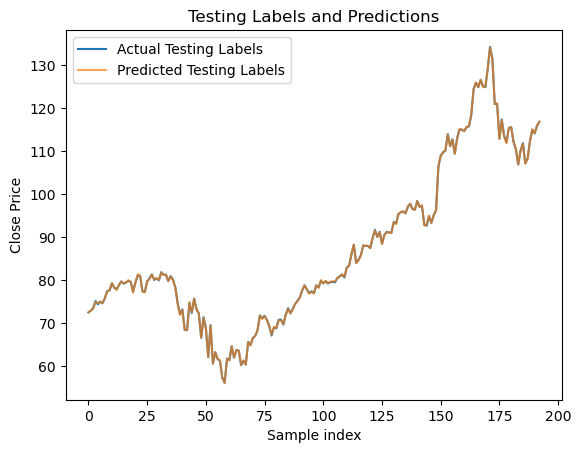

In [10]:
# plot for testing
plt.plot(test_labels_list, label='Actual Testing Labels')
plt.plot(test_predictions_list, label='Predicted Testing Labels', alpha=0.7)
plt.title('Testing Labels and Predictions')
plt.xlabel('Sample index')
plt.ylabel('Close Price')
plt.legend()
plt.show()